In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

from scipy.stats import uniform
from scipy.stats import randint as sp_randint

from sklearn import metrics
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_selector as selector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,  StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold

np.random.seed(0)

lb_make = LabelEncoder()
K_fold  = StratifiedKFold(n_splits=10)

# **I. PREPROCESSING DATA**

In [2]:
titanic_df = pd.read_csv('titanic_train_kagle.csv')
test_df = pd.read_csv('titanic_test_kagle.csv')

In [3]:
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
print(f'train_set shape: {titanic_df.shape}, test_set shape: {test_df.shape}')

train_set shape: (891, 12), test_set shape: (418, 11)


- Survived: Survival (0 = No; 1 = Yes) 
- Pcass: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd) 
- SibSp: Number of Siblings/Spouses Aboard 
- Parch: Number of Parents/Children Aboard 
- Fare: Passenger Fare (British pound) 
- Sex: Sex (male = 1, female = 0) 
- Embarked: Port of Embarkation (C = Cherbourg = 2; Q = Queenstown = 3; S = Southampton = 1) 
- Age: Age

**MISSING DATA**

In [5]:
train_missing = titanic_df.isnull().sum().to_frame().reset_index()
test_missing = test_df.isnull().sum().to_frame().reset_index()
missing_data = train_missing.merge(test_missing, on='index').rename(columns={'0_x':'train', '0_y':'test'})
missing_data

,index,train,test
0,PassengerId,0,0
1,Pclass,0,0
2,Name,0,0
3,Sex,0,0
4,Age,177,86
5,SibSp,0,0
6,Parch,0,0
7,Ticket,0,0
8,Fare,0,1
9,Cabin,687,327


In [6]:
trd, ted = titanic_df.copy(), test_df.copy()
data = [trd, ted]
for dataset in data:
    dataset.drop(['Ticket', 'Cabin'], axis=1, inplace=True)

**UNIQUE DATA**

In [7]:
train_unique = trd.nunique().to_frame().reset_index()
test_unique = ted.nunique().to_frame().reset_index()
unique_data = train_unique.merge(test_unique, on='index').rename(columns={'0_x':'train', '0_y':'test'})
unique_data

,index,train,test
0,PassengerId,891,418
1,Pclass,3,3
2,Name,891,418
3,Sex,2,2
4,Age,88,79
5,SibSp,7,7
6,Parch,7,8
7,Fare,248,169
8,Embarked,3,3


**QUICK DATA OVERVIEW**

In [8]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio # без этого фигуры ниже не отображаются
pio.renderers.default = "iframe"

fig1=px.histogram(titanic_df,
             x='Sex', 
             barmode="group",
             marginal="box", nbins=100,
             color='Survived')

fig2=px.histogram(titanic_df,
             x='Pclass',
             barmode="group",
             marginal="box", #nbins=50,
             color='Survived')

fig3=px.histogram(titanic_df,
             x='Embarked',
             barmode="group",
             marginal="box", #nbins=50,
             color='Survived')

fig4=px.histogram(titanic_df,
             x='SibSp',
             barmode="group",
             marginal="box", #nbins=50,
             color='Survived')

fig5=px.histogram(titanic_df,
             x='Parch',
             barmode="group",
             marginal="box", #nbins=50,
             color='Survived')

fig = make_subplots(rows=1, cols=5, subplot_titles=('Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch'))

fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig1.data[2], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)
fig.add_trace(fig2.data[2], row=1, col=2)
fig.add_trace(fig3.data[0], row=1, col=3)
fig.add_trace(fig3.data[2], row=1, col=3)
fig.add_trace(fig4.data[0], row=1, col=4)
fig.add_trace(fig4.data[2], row=1, col=4)
fig.update_traces(showlegend=False)
fig.add_trace(fig5.data[0], row=1, col=5)
fig.add_trace(fig5.data[2], row=1, col=5)
fig.update_yaxes(title_text="Amount", row=1, col=1)

fig.update_layout(width=900, height=300, title_text='OBSERVATION #1 WITH RESPECT TO SURV/NOT SURV STATUS') 
fig.update_layout(margin=dict(l=0, r=0, t=100, b=0))
fig.show()

In [9]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio # без этого фигуры ниже не отображаются
pio.renderers.default = "iframe"

fig1=px.histogram(titanic_df,
             x='Age',
             #color_discrete_sequence=px.colors.sequential.RdBu, 
             barmode="group",
             marginal="box", nbins=100,
             color='Survived'
                )


fig2=px.histogram(titanic_df,
             x='Fare',
             #color_discrete_sequence=px.colors.sequential.RdBu, 
             barmode="group",
             marginal="box", #nbins=50,
             color='Survived')


fig = make_subplots(rows=2, cols=2, column_widths=[0.4, 0.6], row_heights=[0.3, 0.7], subplot_titles=('Age', 'Fare'))

fig.add_trace(fig1.data[1], row=1, col=1)
fig.add_trace(fig1.data[-1], row=1, col=1)
fig.add_trace(fig1.data[0], row=2, col=1)
fig.add_trace(fig1.data[2], row=2, col=1)
fig.update_traces(showlegend=False)
fig.update_xaxes(title_text="Age", row=2, col=1)
fig.update_yaxes(title_text="Amount", row=2, col=1)

fig.add_trace(fig2.data[1], row=1, col=2)
fig.add_trace(fig2.data[-1], row=1, col=2)
fig.add_trace(fig2.data[0], row=2, col=2)
fig.add_trace(fig2.data[2], row=2, col=2)
fig.update_xaxes(title_text="Fare", row=2, col=2)
fig.update_yaxes(title_text="Amount", row=2, col=2)

fig.update_layout(width=900, height=400, title_text='OBSERVATION #2 WITH RESPECT TO SURV/NOT SURV STATUS') 
fig.update_layout(margin=dict(l=0, r=0, t=100, b=0))
fig.show()

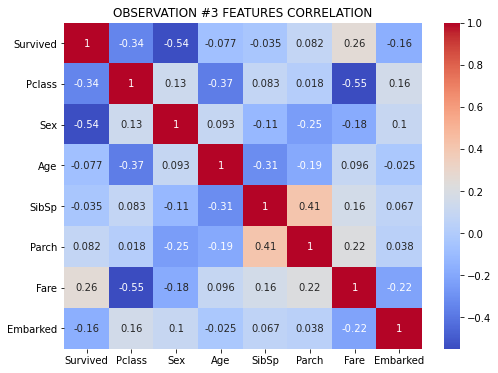

In [10]:
#%matplotlib inline
# посмотрим корреляцию между признаками и выжтванием
plt.figure(figsize=(8,6))
ax = plt.axes()

train_corr=titanic_df.copy().drop('PassengerId', axis=1)

# переведем категории в цифры
train_corr.Sex=lb_make.fit_transform(train_corr.Sex)
train_corr.Embarked=lb_make.fit_transform(train_corr.Embarked) 

features_corr = sns.heatmap(train_corr.corr(), annot=True, cmap='coolwarm') 
features_corr=features_corr.set_yticklabels(features_corr.get_yticklabels(), rotation=0, horizontalalignment='right')
ax.set_title('OBSERVATION #3 FEATURES CORRELATION')
plt.show()

**Resume by observation:**
- выживание тесно связано с полом пассажира
- у женщин больше шансов выжить
- чем ниже класс каюты, тем меньше шансов выжить
- посадка в порту С ведет к бо'льшим шансам выжить
- с ростом кол-ва SibSp шансы выжить уменьшаются
- по возрасту м-у погибшими и выжившими значимых разлиий нет
- но маленькие дети выживают лучше всех
- тарифы: медиана тарифов выживших значительно отличается от медианы погибших


**Features recognition:**
- пол, класс каюты, порт посадки, тарифы могут быть использованы  в качестве признаков для обучения модели
- возможно стоит как-то перобразовать SibSp и Parch, чтобы усилить связь со статусом пассажира
- попробовать перевести возраст в категории и посмотреть, как повыситься предсказывание модели


**FILLING IN MISSED DATA.AGE**

In [11]:
for dataset in data:
    dataset['Title'] = dataset.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [12]:
# для создания словаря титулов нужно убедиться, что наборы титулов в двух df не отличаются
from deepdiff import DeepDiff

trd_titles = trd.groupby(['Pclass']).Title.apply(set).to_dict()
ted_titles = ted.groupby(['Pclass']).Title.apply(set).to_dict()

diff = DeepDiff(trd_titles, ted_titles)
diff['set_item_added']
# как видим, trd не содержит Pclass 1: Dona, Pclass 3: MS - нужно это учесть при составлении словаря титулов

[root[1]['Dona'], root[3]['Ms']]

In [13]:
# vocab for the age-gap replacement
mean_age_df = trd.groupby(['Pclass','Sex','Title'], as_index=False).agg({'PassengerId':'count', 'Age':'mean'}).rename(columns={'PassengerId':'Amount', 'Age':'mean_Age'}).fillna(trd.Age.mean())
std_age = trd.groupby(['Pclass','Sex','Title'], as_index=False).Age.std().rename(columns={'Age':'std_Age'}).fillna(0)
mean_age_df = mean_age_df.merge(std_age, how='outer', on=['Pclass','Sex','Title'])
# добавляем недостающие титулы
dona_1 = trd.loc[(trd.Pclass==1)&(trd.Sex=='female'), 'Age'].mean()
ms_3 = trd.loc[(trd.Pclass==3)&(trd.Sex=='female'), 'Age'].mean()
mean_age_df = mean_age_df.append(pd.DataFrame([[1,'female', 'Dona', 1, dona_1, 0],[3,'female', 'Ms', 1, ms_3, 0]], 
                                              columns=['Pclass','Sex','Title','Amount','mean_Age','std_Age']), ignore_index=True)
mean_age_df.head()

,Pclass,Sex,Title,Amount,mean_Age,std_Age
0,1,female,Dr,1,49.0,0.000000
1,1,female,Lady,1,48.0,0.000000
2,1,female,Miss,46,30.0,12.852308
3,1,female,Mlle,2,24.0,0.000000
4,1,female,Mme,1,24.0,0.000000


In [14]:
def AgeFillIn(df):
        """ 
        Ф-я возвращает возраст:
        Если возраст в ячейке пропущен ф-я берет данные из диапазона: 
        ср. возраст по классу каюты, полу, титулу  +/- ст. откл,
        в противном случае оставляет данные как есть 
        """
        Age, pclass, sex, title = df[0], df[1], df[2], df[3]

        if pd.isnull(Age):
            filter_data = (mean_age_df.Pclass==pclass)&(mean_age_df.Sex==sex)&(mean_age_df.Title==title)
            res = mean_age_df.loc[filter_data, ['mean_Age', 'std_Age']]
            mean_age, std_age = res.mean_Age, res.std_Age
            age = [uniform.rvs(mean_age+std_age, mean_age-std_age)][0]
            return age
        else:
            return Age
for dataset in data:
    dataset['Age_new'] = dataset[['Age','Pclass','Sex','Title']].apply(AgeFillIn, axis = 1)

In [15]:
# check for missing age data
trd.Age_new.isnull().sum(), ted.Age_new.isnull().sum()

(0, 0)

In [16]:
# mean age after the missed data was filled in
trd.Age_new.mean(), ted.Age_new.mean()

(33.296491395105924, 33.51649591752552)

In [17]:
# check for missing data (Age column will be dropped)
train_missing = trd.isnull().sum().to_frame().reset_index()
test_missing = ted.isnull().sum().to_frame().reset_index()
missing_data = train_missing.merge(test_missing, on='index').rename(columns={'0_x':'train', '0_y':'test'})
missing_data

,index,train,test
0,PassengerId,0,0
1,Pclass,0,0
2,Name,0,0
3,Sex,0,0
4,Age,177,86
5,SibSp,0,0
6,Parch,0,0
7,Fare,0,1
8,Embarked,2,0
9,Title,0,0


Заполним оставшиеся пропуски позже при помощи SimpleImputer

# **II. FEATURES' DESIGN**

**FAMILY**

- наличие родственников на борту повышает шансы выжит
- разделим пассажиров на 3 категории: одинокие/с семьей до 4 человек/остальное - Family1
- разделим пассажирова на 2 категории: одинокие/с семьей - Family2

In [18]:
for dataset in data:
    dataset['Family'] = dataset['SibSp'] +dataset['Parch']
    dataset['Family2'] = pd.cut(dataset.Family, bins=[-1,0, 4, 10], labels=['Alone','1-4', '>4'])
    dataset['Family1'] = pd.cut(dataset.Family, bins=[-1,0,10], labels=['Alone','withFamily'])

In [19]:
trd.groupby('Family1', as_index=False).agg({'PassengerId':'count', 'Survived':'mean'}).rename(columns={'PassengerId':'Amount'})

,Family1,Amount,Survived
0,Alone,537,0.303538
1,withFamily,354,0.505650


In [20]:
trd.groupby('Family2', as_index=False).agg({'PassengerId':'count', 'Survived':'mean'}).rename(columns={'PassengerId':'Amount'})

,Family2,Amount,Survived
0,Alone,537,0.303538
1,1-4,307,0.560261
2,>4,47,0.148936


**AGE**

- нужно помнить, что отсуствующие данные были компенсированы
- маленькие дати до 5 лет выживают лучше 
- для того, чтобы не зависеть от искусственных данных переведем возраст в следующие 2 вида:
    - разделим пассажиров на 3 категории: дети до 5 лет, те у кого есть данные, остальные - Age_cat1
    - разделим пассажиров на 2 категории: дети до 5 лет и остальные - Age_cat2

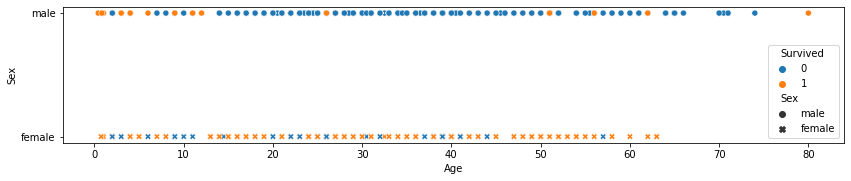

In [132]:
# распределение известных  данных по возрасту с учетом пола и статуса выживания
fig_dims = (14, 2.5)
fig = plt.subplots(figsize=fig_dims) 
sns.scatterplot(x=titanic_df["Age"], y=titanic_df["Sex"], hue=titanic_df["Survived"], style=titanic_df['Sex'])
plt.show()
# основано на данных до компенсации возраста

In [22]:
#titanic_df['Age_category'] = pd.cut(titanic_df.Age, bins=[0,5,90], labels=['Kid','Others']) 
titanic_df['Age_category']  = titanic_df.Age.apply(lambda x: np.where(x <=5, 'Kid', np.where(x>5, 'YES', 'NO')))
titanic_df.groupby(['Age_category'], as_index=False).agg({'PassengerId':'count', 'Survived':'mean'}).rename(columns={'PassengerId':'Amount'})
# Дети до 5 выживают значительно лучше, чем все остальные

,Age_category,Amount,Survived
0,Kid,44,0.704545
1,NO,177,0.293785
2,YES,670,0.386567


In [23]:
# применим 2 варианта
for dataset in data:
    dataset['Age_cat1'] = dataset.Age.apply(lambda x: np.where(x <=5, 'Kid', np.where(x>5, 'Yes', 'No')))
    dataset['Age_cat2'] = pd.cut(dataset.Age_new, bins=[0,5,90], labels=['Kids','Others']) 

**FARE**

- мы видели выше, что погибло очень много пассажиров с дешевыми билетами
- создадим 3 категории пассажиров: с билетами до 11, до 50 и остальные

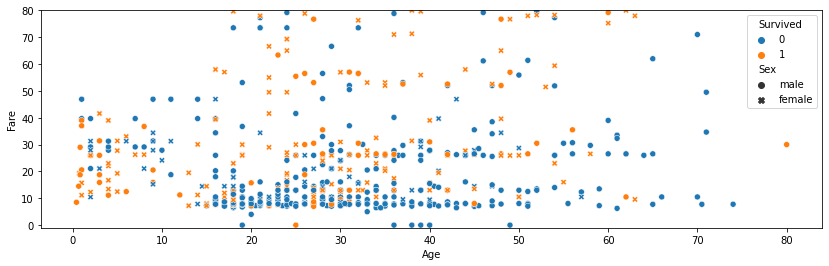

In [24]:
fig_dims = (14, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(x=titanic_df["Age"], y=titanic_df["Fare"], hue=titanic_df["Survived"], style=titanic_df['Sex'])
ax.set_ylim(-1, 80)
plt.show()
# основано на данных до компенсации возраста, показаны только значения Fare в диапазоне  0-80

**Покажем, что между Survived и Fare существует взаимосвязь**

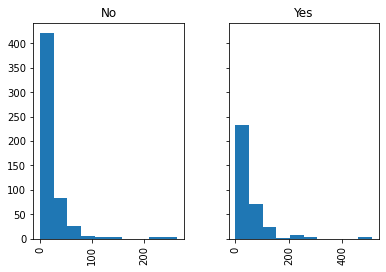

In [173]:
fare = trd.copy()[['Fare', 'Survived']]
fare.loc[:,'Survived'].replace([0,1],['No','Yes'], inplace=True)
fare.hist(column="Fare",by="Survived",sharey=True);


In [192]:
fare.loc[:,'fare_groups'] = pd.cut(fare.Fare, bins=[-1,11,50, 515], labels=['Chip','Mid', 'Others'])
fare['Count'] = 1
fare_grouped = fare.groupby(['Survived', 'fare_groups'], as_index=False).Count.sum()
fare_observation = fare_grouped.pivot(index='Survived', columns='fare_groups', values='Count')
fare_observation 

fare_groups,Chip,Mid,Others
Survived,,,
No,288,210,51
Yes,76,157,109


H_0: the observed frequencies of two categories in the table are independent (there is no relationship between the Survived and Fare variables)

H_1: the observed frequencies of two categories in the table are dependent (there is relationship between the Survived and Fare variables)

In [193]:
from scipy.stats import chi2_contingency

# Chi-square statistic
chi2, p_value, degree_of_freedom, expected = chi2_contingency(fare_observation)

print('chi2:{}\ndegree_of_freedom:{}\np-value:{}'.format(chi2,degree_of_freedom,p_value))
# p-value = 1.3*10^(-24) < 0.05 --> we regect H_0 --> there is relationship between the Survived and Fare variables

chi2:109.9975884442671
degree_of_freedom:2
p-value:1.301149376636145e-24


In [25]:
trd['Fare_category'] = pd.cut(trd.Fare, bins=[-1,11,50, 515], labels=['Chip','Mid', 'Others']) 
trd.groupby(['Fare_category'], as_index=False).agg({'PassengerId':'count', 'Survived':'mean'}).rename(columns={'PassengerId':'Amount'})
# видим, что пассажиры с билетами стоимостью до 11$ имеют шансы выжить хуже

,Fare_category,Amount,Survived
0,Chip,364,0.208791
1,Mid,367,0.427793
2,Others,160,0.681250


In [133]:
# применим 3 билетные группы:билеты до 11$, 50$  и остальные
for dataset in data:
    dataset['Fare_category'] = pd.cut(dataset.Fare, bins=[-1,11,50, 515], labels=['Chip','Mid', 'Others']) 

**Перед выбором признаков посмотрим на корреляционную матрицу**

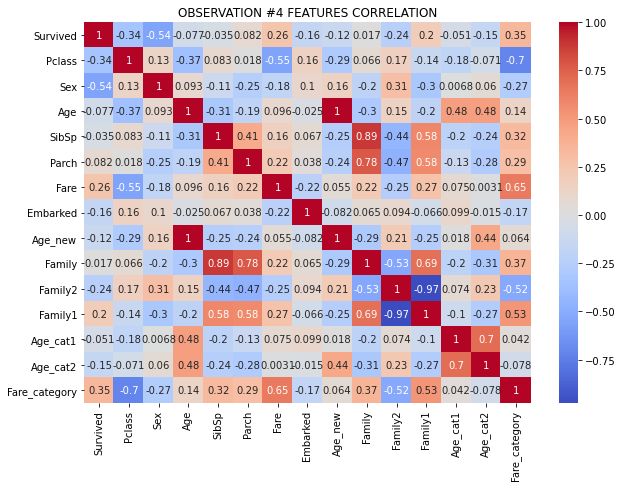

In [27]:
# посмотрим что дали дополнительные признаки
plt.figure(figsize=(10,7))
ax = plt.axes()

train_corr=trd.copy().drop('PassengerId', axis=1)

# переведем категории в цифры
train_corr.Sex=lb_make.fit_transform(train_corr.Sex)
train_corr.Embarked=lb_make.fit_transform(train_corr.Embarked) 
train_corr.Family1=lb_make.fit_transform(train_corr.Family1)
train_corr.Family2=lb_make.fit_transform(train_corr.Family2) 
train_corr.Age_cat1=lb_make.fit_transform(train_corr.Age_cat1)
train_corr.Age_cat2=lb_make.fit_transform(train_corr.Age_cat2) 
train_corr.Fare_category=lb_make.fit_transform(train_corr.Fare_category) 

features_corr = sns.heatmap(train_corr.corr(), annot=True, cmap='coolwarm') 
features_corr=features_corr.set_yticklabels(features_corr.get_yticklabels(), rotation=0, horizontalalignment='right')
ax.set_title('OBSERVATION #4 FEATURES CORRELATION')
plt.show()

Оставим для обучения признаки с наибольшим значениями в матрице корреляции по отношению к Survived:

'Sex','Pclass','Fare','Fare_category','Embarked','Age_new','Family1','Family2','Age_cat2'

**Для дальнейшей работы нам нужно убрать лишние колонки и перевести все данные типа object в тип category**

In [28]:
trd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    891 non-null    int64   
 1   Survived       891 non-null    int64   
 2   Pclass         891 non-null    int64   
 3   Name           891 non-null    object  
 4   Sex            891 non-null    object  
 5   Age            714 non-null    float64 
 6   SibSp          891 non-null    int64   
 7   Parch          891 non-null    int64   
 8   Fare           891 non-null    float64 
 9   Embarked       889 non-null    object  
 10  Title          891 non-null    object  
 11  Age_new        891 non-null    float64 
 12  Family         891 non-null    int64   
 13  Family2        891 non-null    category
 14  Family1        891 non-null    category
 15  Age_cat1       891 non-null    object  
 16  Age_cat2       891 non-null    category
 17  Fare_category  891 non-null    cate

In [29]:
for dataset in data:
    dataset.drop(['Name', 'Title', 'Age', 'SibSp', 'Parch', 'Family', 'Age_cat1'], axis=1, inplace=True)
    dataset['Sex'] = dataset.Sex.astype('category')
    dataset['Embarked'] = dataset.Embarked.astype('category')
    dataset['Pclass'] = dataset.Pclass.astype('category')
  

In [30]:
trd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    891 non-null    int64   
 1   Survived       891 non-null    int64   
 2   Pclass         891 non-null    category
 3   Sex            891 non-null    category
 4   Fare           891 non-null    float64 
 5   Embarked       889 non-null    category
 6   Age_new        891 non-null    float64 
 7   Family2        891 non-null    category
 8   Family1        891 non-null    category
 9   Age_cat2       891 non-null    category
 10  Fare_category  891 non-null    category
dtypes: category(7), float64(2), int64(2)
memory usage: 34.9 KB


In [134]:
# check for missing data
train_missing = trd.isnull().sum().to_frame().reset_index()
test_missing = ted.isnull().sum().to_frame().reset_index()
missing_data = train_missing.merge(test_missing, on='index').rename(columns={'0_x':'train', '0_y':'test'})
missing_data

,index,train,test
0,PassengerId,0,0
1,Pclass,0,0
2,Sex,0,0
3,Fare,0,1
4,Embarked,2,0
5,Age_new,0,0
6,Family2,0,0
7,Family1,0,0
8,Age_cat2,0,0
9,Fare_category,0,1


пропущенные данные будут заполнены дальше

# **III. SUPERVISED LEARNING**

In [32]:
models_result = pd.DataFrame()

In [66]:

def models(X, y):
    global models_result
    """
    Функция 
    - трансформирует данные: применяет StandardScaler к числовым данным и кодирует категориальные данные;
    - применяет GridSearchCV для тюнига гиперпараметров
    - оценивает модели на валидационных данных и записывает оценки в df
    - демонстрирует полученные оценки по каждой модели и показывает важность признаков через permutation_importance plot
    - возвращает 4 модели: RandomForestClassifier, DecisionTreeClassifier, GradientBoostingClassifier, VotingClassifier
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

    # ######### preprocessing ##########################################
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")), ("scaler",StandardScaler())] 
        )

    categorical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="most_frequent")),('encoder',OneHotEncoder(handle_unknown="ignore"))]
        )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )
    # ######### RandomForestClassifier #################################

    pipe_RFC = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(random_state=42))] 
    )

    parameter_grid = {'classifier__criterion': [None],
                        'classifier__min_samples_split':[sp_randint.rvs(2,14,2)],
                        'classifier__min_samples_leaf': [sp_randint.rvs(10,16,2)],
                        'classifier__n_estimators' : [sp_randint.rvs(500,600,50)],
                        'classifier__criterion': ["gini", "entropy"]}

    gsRFC = GridSearchCV(estimator=pipe_RFC, param_grid = parameter_grid, cv=K_fold, scoring="accuracy", n_jobs= -1, verbose = 1) 

    gsRFC = gsRFC.fit(X_train, y_train)

    modelRFC = gsRFC.best_estimator_
    # ########################
    result = permutation_importance(
        gsRFC, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx]
    )
    ax.set_title("RFC: Permutation Importances (train set)")
    fig.tight_layout()
    plt.show()
    # #######################

    y_pred_RFC = modelRFC.predict(X_valid)
    print('RFC: ', X_train.columns)
    print()
    print('RandomForestClassifier (RFC): classification_report for validation test')
    print()
    print(classification_report(y_valid,y_pred_RFC))

    accuracy_RFC = cross_val_score(estimator=modelRFC, X=X_train, y=y_train, cv=K_fold, scoring='accuracy')
    f1_RFC = cross_val_score(estimator=modelRFC, X=X_train, y=y_train, cv=K_fold, scoring='f1')
    ROCAUC_RFC = cross_val_score(estimator=modelRFC, X=X_train, y=y_train, cv=K_fold, scoring='roc_auc')
    print(f'RFC_validation test: accuracy - {accuracy_RFC.mean()}, f1 - {f1_RFC.mean()}, roc_auc - {ROCAUC_RFC.mean()}')

#     results_dict = {'type':['RFC'],
#                     'len': [len(X_train.columns)],
#                     'features':[list(X_train.columns)],
#                     'model':[modelRFC], 
#                     'accuracy':[accuracy_RFC.mean()],
#                     'f1':[f1_RFC.mean()],
#                     'ROC-AUC':[ROCAUC_RFC.mean()],
#                     'kaggle_score':[''],
#                    }


#     result = pd.DataFrame.from_dict(results_dict)
#     models_result = models_result.append(result)
    print('#########################################################')

    # ######### DecissionTreeClassifier ################################

    pipe_DTC = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier(random_state=42))])

    parameter_grid = {'classifier__max_depth':[1,2],
                      'classifier__ccp_alpha':[0.001, 0.1, 100]}

    gsDTC = GridSearchCV(estimator=pipe_DTC, param_grid = parameter_grid, cv=K_fold,scoring="accuracy", n_jobs= -1, verbose = 1) 

    gsDTC = gsDTC.fit(X_train, y_train)

    modelDTC = gsDTC.best_estimator_

    # #######################
    result = permutation_importance(
        gsDTC, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx]
    )
    ax.set_title("DTC: Permutation Importances (train set)")
    fig.tight_layout()
    plt.show()
    # #######################

    y_pred_DTC = modelDTC.predict(X_valid)
    print('DTC: ', X_train.columns)
    print()
    print('DecisionTreeClassifier (DTC): classification_report for validation test')
    print()
    print(classification_report(y_valid,y_pred_DTC))

    accuracy_DTC = cross_val_score(estimator=modelDTC, X=X_train, y=y_train, cv=K_fold, scoring='accuracy')
    f1_DTC = cross_val_score(estimator=modelDTC, X=X_train, y=y_train, cv=K_fold, scoring='f1')
    ROCAUC_DTC = cross_val_score(estimator=modelDTC, X=X_train, y=y_train, cv=K_fold, scoring='roc_auc')
    print(f'DTC_validation test: accuracy - {accuracy_DTC.mean()}, f1 - {f1_DTC.mean()}, roc_auc - {ROCAUC_DTC.mean()}')

#     results_dict = {'type':['DTC'],
#                     'len': [len(X_train.columns)],
#                     'features':[list(X_train.columns)],
#                     'model':[modelDTC], 
#                     'accuracy':[accuracy_DTC.mean()],
#                     'f1':[f1_DTC.mean()],
#                     'ROC-AUC':[ROCAUC_DTC.mean()],
#                     'kaggle_score':[''],
#                    }


#     result = pd.DataFrame.from_dict(results_dict)
#     models_result = models_result.append(result)
    print('#########################################################')

    # ######### GradientBoostingClassifier ################################

    pipe_GBC = Pipeline(
        steps=[("preprocessor", preprocessor),("classifier", GradientBoostingClassifier(random_state=42))] 
    )

    # GBC.get_params().keys()
    gb_param_grid = {
                   'classifier__criterion': ['friedman_mse', 'squared_error', 'mse'],
                  'classifier__loss' : ["deviance"],
                  'classifier__n_estimators' : [sp_randint.rvs(100,500,100)],
                  'classifier__learning_rate': [uniform.rvs(0.001, 0.1)],
                  'classifier__max_depth': [sp_randint.rvs(4,16, 4)],
                  'classifier__min_samples_leaf': [sp_randint.rvs(100,250,50)],
                  'classifier__max_features': [0.3, 0.1]
                  }

    gsGBC = GridSearchCV(pipe_GBC, param_grid = gb_param_grid, cv=K_fold, 
                         scoring="accuracy", n_jobs= 4, verbose = 1)

    gsGBC.fit(X_train,y_train)

    modelGBC = gsGBC.best_estimator_
    # #######################
    result = permutation_importance(
        gsGBC, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx]
    )
    ax.set_title("GBC: Permutation Importances (train set)")
    fig.tight_layout()
    plt.show()
    # #######################

    y_pred_GBC = modelGBC.predict(X_valid)
    print('GDC: ', X_train.columns)
    print()
    print('GradientBoostingClassifier (GBC): classification_report for validation test')
    print()
    print(classification_report(y_valid,y_pred_GBC, labels=np.unique(y_pred_GBC)))
 
    accuracy_GBC = cross_val_score(estimator=modelGBC, X=X_train, y=y_train, cv=K_fold, scoring='accuracy')
    f1_GBC = cross_val_score(estimator=modelGBC, X=X_train, y=y_train, cv=K_fold, scoring='f1')
    ROCAUC_GBC = cross_val_score(estimator=modelGBC, X=X_train, y=y_train, cv=K_fold, scoring='roc_auc')
    print(f'GBC_validation test: accuracy - {accuracy_GBC.mean()}, f1 - {f1_GBC.mean()}, roc_auc - {ROCAUC_GBC.mean()}')


#     results_dict = {'type':['GBC'],
#                     'len': [len(X_train.columns)],
#                     'features':[list(X_train.columns)],
#                     'model':[modelGBC], 
#                     'accuracy':[accuracy_GBC.mean()],
#                     'f1':[f1_GBC.mean()],
#                     'ROC-AUC':[ROCAUC_GBC.mean()],
#                     'kaggle_score':[''],
#                    }


#     result = pd.DataFrame.from_dict(results_dict)
#     models_result = models_result.append(result)
    print('#########################################################')

    # ########## VotingClassifier #####################################

    VotingPredictor = VotingClassifier(estimators =
                               [ 
                                ('dtc', modelDTC),
                                ('rfc', modelRFC),
                               ],
                               voting='soft', n_jobs = 4)

    VotingPredictor = VotingPredictor.fit(X_train, y_train)

    accuracy_VOT = cross_val_score(estimator=VotingPredictor, X=X_train, y=y_train, cv=K_fold, scoring='accuracy')
    f1_VOT = cross_val_score(estimator=VotingPredictor, X=X_train, y=y_train, cv=K_fold, scoring='f1')
    ROCAUC_VOT = cross_val_score(estimator=VotingPredictor, X=X_train, y=y_train, cv=K_fold, scoring='roc_auc')

    print('VotingClassifier: ', X_train.columns)
    print(f'VotingClassifier_validation test: accuracy - {accuracy_VOT.mean()}, f1 - {f1_VOT.mean()}, roc_auc - {ROCAUC_VOT.mean()}')

#     results_dict = {'type':['VotingClassifier'],
#                     'len': [len(X_train.columns)],
#                     'features':[list(X_train.columns)],
#                     'model':[VotingPredictor], 
#                     'accuracy':[accuracy_VOT.mean()],
#                     'f1':[f1_VOT.mean()],
#                     'ROC-AUC':[ROCAUC_VOT.mean()],
#                     'kaggle_score':[''],
#                    }

#     result = pd.DataFrame.from_dict(results_dict)
#     models_result = models_result.append(result)
    print('#########################################################')
    print()
    return modelRFC, modelDTC, modelGBC, VotingPredictor

Fitting 10 folds for each of 2 candidates, totalling 20 fits


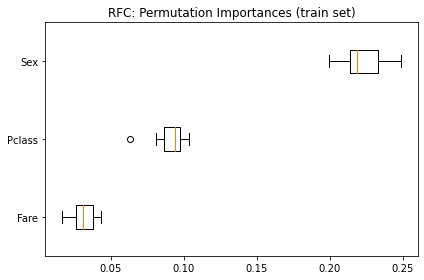

RFC:  Index(['Sex', 'Pclass', 'Fare'], dtype='object')

RandomForestClassifier (RFC): classification_report for validation test

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       134
           1       0.82      0.65      0.72        89

    accuracy                           0.80       223
   macro avg       0.81      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223

RFC_validation test: accuracy - 0.7979647218453187, f1 - 0.6805288119059815, roc_auc - 0.8169397837934425
#########################################################
Fitting 10 folds for each of 6 candidates, totalling 60 fits


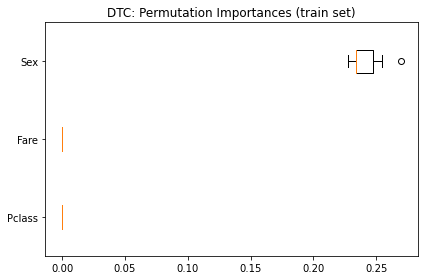

DTC:  Index(['Sex', 'Pclass', 'Fare'], dtype='object')

DecisionTreeClassifier (DTC): classification_report for validation test

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       134
           1       0.74      0.71      0.72        89

    accuracy                           0.78       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223

DTC_validation test: accuracy - 0.7875169606512891, f1 - 0.7039482328238109, roc_auc - 0.7649198606271778
#########################################################
Fitting 10 folds for each of 6 candidates, totalling 60 fits


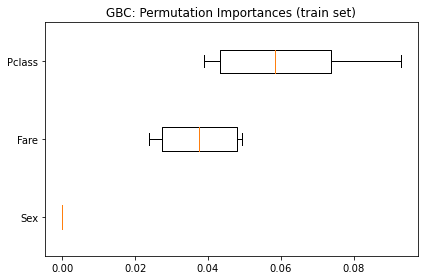

GDC:  Index(['Sex', 'Pclass', 'Fare'], dtype='object')

GradientBoostingClassifier (GBC): classification_report for validation test

              precision    recall  f1-score   support

           0       0.77      0.72      0.74       134
           1       0.61      0.67      0.64        89

    accuracy                           0.70       223
   macro avg       0.69      0.70      0.69       223
weighted avg       0.71      0.70      0.70       223

GBC_validation test: accuracy - 0.6751696065128902, f1 - 0.5642199014643233, roc_auc - 0.6980435093361923
#########################################################
VotingClassifier:  Index(['Sex', 'Pclass', 'Fare'], dtype='object')
VotingClassifier_validation test: accuracy - 0.7875169606512891, f1 - 0.7039482328238109, roc_auc - 0.8190512820512821
#########################################################



In [128]:
from itertools import combinations
# запускает ф-ю models в виде 1 или 2 варианта
train = trd.copy()

""""
Вариант1: 
 - составляет все возможные комбинации признаков без повторения, без учета порядка (АВ=ВА), мин кол-во признаков = 3
 - отправляет полученные комбинации в ф-ю models
"""

#subset_feature =['Sex','Pclass','Fare','Fare_category','Embarked','Age_new','Family1','Family2','Age_cat2']
# count = 0
# stop, start = 3, len(subset_feature)+1
# for r in range(stop, start):
#     features_combinations = list(combinations(subset_feature, r))
#     count+=1
#     for features in features_combinations:
#         X = train[list(features)]
#         y = train.Survived
#         print(f'# {count} ################################################')
#         modelRFC,modelDTC,modelGBC,VotingPredictor   = models(X, y)
 
""""
Вариант2: отправляет лист признаков в ф-ю models
"""
subset_feature = ['Sex', 'Pclass', 'Fare']
X = train[subset_feature]
y = train.Survived

modelRFC,modelDTC,modelGBC,VotingPredictor  = models(X, y)

# переустановка индексов
# models_result.reset_index(inplace=True, drop=True)


In [36]:
models_result.to_csv('kaggle_titanic_all_features_permutation.csv')

In [199]:
result = pd.read_csv('kaggle_titanic_all_features_permutation.csv')
result.sort_values('kaggle_score', ascending=False).head(9)
# result.head()

,Unnamed: 0,type,len,features,model,accuracy,f1,ROC-AUC,kaggle_score
0,0,RFC,3,"['Sex', 'Pclass', 'Fare']","Pipeline(steps=[('preprocessor',\n ...",0.817458,0.714308,0.824996,0.78468
8,8,RFC,3,"['Sex', 'Pclass', 'Embarked']","Pipeline(steps=[('preprocessor',\n ...",0.813026,0.688199,0.827945,0.77751
340,340,RFC,4,"['Sex', 'Pclass', 'Fare', 'Embarked']","Pipeline(steps=[('preprocessor',\n ...",0.796517,0.777510,0.777510,0.77751
1108,1108,RFC,5,"['Sex', 'Embarked', 'Age_new', 'Family2', 'Age...","Pipeline(steps=[('preprocessor',\n ...",0.806943,0.738786,0.819544,0.77270
336,336,RFC,4,"['Sex', 'Pclass', 'Fare', 'Fare_category']","Pipeline(steps=[('preprocessor',\n ...",0.820443,0.721705,0.825642,0.77033
543,543,VotingClassifier,4,"['Sex', 'Embarked', 'Family2', 'Age_cat2']","VotingClassifier(estimators=[('dtc',\n ...",0.812935,0.739006,0.808818,0.77033
544,544,RFC,4,"['Sex', 'Age_new', 'Family1', 'Family2']","Pipeline(steps=[('preprocessor',\n ...",0.808458,0.745644,0.817055,0.77033
92,92,RFC,3,"['Sex', 'Age_new', 'Family2']","Pipeline(steps=[('preprocessor',\n ...",0.808435,0.741398,0.816872,0.76555
559,559,VotingClassifier,4,"['Sex', 'Family1', 'Family2', 'Age_cat2']","VotingClassifier(estimators=[('dtc',\n ...",0.812935,0.739006,0.805790,0.76555


In [ ]:
#result.iloc[340, 8] = 0.77751
# result.iloc[336, 8] = 0.77033
# result.iloc[0, 8]= 0.78468
# result.iloc[8, 8]= 0.77751
# result.iloc[559, 8]= 0.76555
# result.iloc[543, 8]= 0.77033
# result.to_csv('kaggle_titanic_all_features_permutation.csv')


In [130]:
set_config(display="diagram")
VotingPredictor

VotingClassifier(estimators=[('dtc',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x0000025A0EFAC7C0>),
                                                                               ('cat',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='most_fre...
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('encoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x00000259F701E580>)])),
                                              ('classifier',
                                               RandomForestClassifier(min_samples_leaf=17,
                                                                      min_samples_split=11,
                                                                      n_estimators=618,
                                                                      random_state=42))]))],
                 n_jobs=4, voting='soft')

In [131]:
modelRFC

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000259F128BD30>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000259F701E580>)])),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=17,
                                        min_samples_split=11, n_estimators=618,
                                        random_state=42))])

In [117]:
# Применение модели к тестовым данным и запись в файл для Kaggle
print(f'trd:{trd.shape}, ted: {ted.shape}')

X_train = trd[subset_feature]
label_train = trd.Survived
passengerId = ted.PassengerId
X_test = ted[subset_feature]

print(f'X_train:{X_train.shape}, X_test: {X_test.shape}')

# RFC ############################
modelRFC.fit(X_train, label_train)
label_pred_RFC = modelRFC.predict(X_test)

RFC_model = pd.DataFrame({'PassengerId':passengerId,'Survived':label_pred_RFC}).set_index('PassengerId')
RFC_model.Survived = RFC_model.Survived.astype(int)
print(RFC_model.Survived.sum())

RFC_model.to_csv('kaggle_titanic_RFC_submission.csv', index_label='PassengerId')
submission_RFC= pd.read_csv('kaggle_titanic_RFC_submission.csv')
print(submission_RFC.columns)
print('check:', submission_RFC.Survived.sum())

# DTC ############################
# modelDTC.fit(X_train, label_train)
# label_pred_DTC = modelDTC.predict(X_test)

# DTC_model = pd.DataFrame({'PassengerId':passengerId,'Survived':label_pred_DTC}).set_index('PassengerId')
# DTC_model.Survived = DTC_model.Survived.astype(int)
# print(DTC_model.Survived.sum())

# DTC_model.to_csv('kaggle_titanic_DTC_submission.csv', index_label='PassengerId')
# submission_DTC= pd.read_csv('kaggle_titanic_DTC_submission.csv')
# print(submission_DTC.columns)
# print('check:', submission_DTC.Survived.sum())

# # VC ############################
# VotingPredictor.fit(X_train, label_train)
# label_pred_Voting = VotingPredictor.predict(X_test)

# Voting_Model = pd.DataFrame({"PassengerId": passengerId,"Survived": label_pred_Voting}).set_index('PassengerId')
# Voting_Model.Survived = Voting_Model.Survived.astype(int)
# print(Voting_Model.Survived.sum())

# Voting_Model.to_csv('Kaggle_titanic_MIX_submission.csv', index_label='PassengerId')
# submission_MIX = pd.read_csv('Kaggle_titanic_Mix_submission.csv')
# print(submission_MIX.columns)
# print('check:', submission_MIX.Survived.sum())

trd:(891, 11), ted: (418, 10)
X_train:(891, 4), X_test: (418, 4)
131
Index(['PassengerId', 'Survived'], dtype='object')
check: 131
